# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [1]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


## Loading Images

### Parameters

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy')
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy')
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks.npy')

In [4]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy')
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy')
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks.npy')

In [5]:
print(X_train.shape)
print(Y_train.shape)

(1208, 256, 256, 3)
(1208, 256, 256, 1)


In [6]:
# Get and resize train images and masks
#X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#print(X_train.shape)
#print(Y_train.shape)

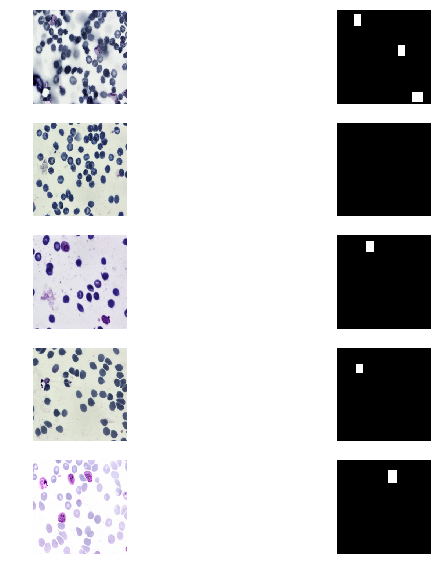

In [7]:
n_images = 5
fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [8]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [10]:
def get_metrics_grafics(results):
    # 'val_loss', 'val_my_iou_metric', 'loss', 'my_iou_metric'
    plt.figure(figsize=(20,10))
    ## LOSS
    plt.subplot(221)
    plt.plot(results.history['loss'], label='Training loss')
    plt.plot(results.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    ## Intersection over union
    plt.subplot(222)
    plt.plot(results.history['my_iou_metric'], label='Training IoU')
    plt.plot(results.history['val_my_iou_metric'], label='Validation IoU')
    plt.legend(frameon=False)

    plt.show()

## U-Net

![title](../../u-net-architecture.png)

In [11]:
def unet(input_size = (128,128,3), dropout_rate=0.2, learning_rate=0.004):
    inputs = Input(input_size)

    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(rate=dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(rate=dropout_rate)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = [my_iou_metric])

    return model

### Test Model

In [12]:
model = unet(input_size = (IMG_HEIGHT,IMG_WIDTH,3), dropout_rate=0.2, learning_rate=0.0001)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________

In [13]:

limit = 300
checkpointer = ModelCheckpoint('model-unet-malaria-kaggle-20190703_00.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=50, 
#                    callbacks=[checkpointer])

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=15, epochs=150, 
                    callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 966 samples, validate on 242 samples
Epoch 1/50
966/966 [==============================] - 46s 48ms/step - loss: 0.0835 - my_iou_metric: 0.0000e+00 - val_loss: 0.0725 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.07247, saving model to model-unet-malaria-kaggle-20190703_00.h5
Epoch 2/50
966/966 [==============================] - 40s 41ms/step - loss: 0.0660 - my_iou_metric: 0.0000e+00 - val_loss: 0.0627 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_loss improved from 0.07247 to 0.06269, saving model to model-unet-malaria-kaggle-20190703_00.h5
Epoch 3/50
966/966 [==============================] - 40s 41ms/step - loss: 0.0589 - my_iou_metric: 0.0000e+00 - val_loss: 0.0549 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_loss improved from 0.06269 to 0.05492, saving model to model-unet-malaria-kaggle-20190703_00.h5
Epoch 4/50
966/966 [==============================] - 40s 41ms/step - loss: 0.0482

966/966 [==============================] - 40s 42ms/step - loss: 0.0039 - my_iou_metric: 0.5421 - val_loss: 0.0586 - val_my_iou_metric: 0.3134

Epoch 00036: val_loss did not improve from 0.02794
Epoch 37/50
966/966 [==============================] - 40s 41ms/step - loss: 0.0037 - my_iou_metric: 0.5441 - val_loss: 0.0564 - val_my_iou_metric: 0.3417

Epoch 00037: val_loss did not improve from 0.02794
Epoch 38/50
966/966 [==============================] - 39s 41ms/step - loss: 0.0031 - my_iou_metric: 0.5622 - val_loss: 0.0547 - val_my_iou_metric: 0.3233

Epoch 00038: val_loss did not improve from 0.02794
Epoch 39/50
966/966 [==============================] - 39s 40ms/step - loss: 0.0027 - my_iou_metric: 0.5802 - val_loss: 0.0611 - val_my_iou_metric: 0.3384

Epoch 00039: val_loss did not improve from 0.02794
Epoch 40/50
966/966 [==============================] - 39s 41ms/step - loss: 0.0025 - my_iou_metric: 0.5882 - val_loss: 0.0568 - val_my_iou_metric: 0.3293

Epoch 00040: val_loss did no

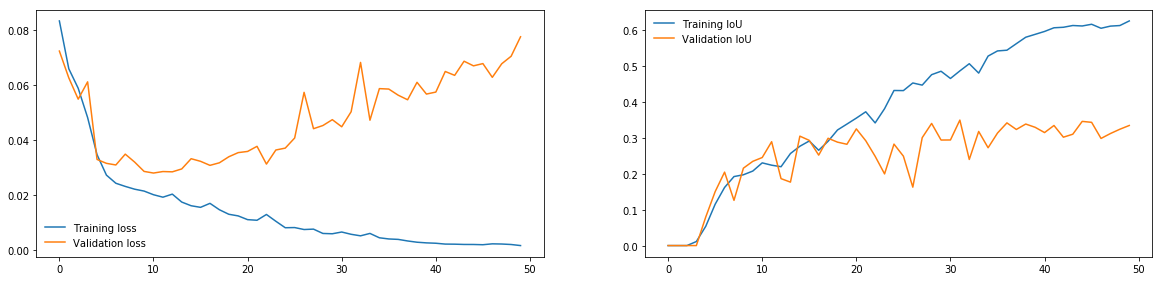

In [14]:
get_metrics_grafics(results)

In [15]:
results_test = model.evaluate(x = X_test, y = Y_test)

120/120 [==============================] - 5s 46ms/step


In [16]:
results_test

[0.22362126807371777, 0.05598611086606979]

## Predictions

In [30]:
# Predict on train, val and test
model = load_model('model-unet-malaria-kaggle-20190703_00.h5', custom_objects={'my_iou_metric': my_iou_metric})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (X_test[i].shape[0], X_test[i].shape[1]), 
                                       mode='constant', preserve_range=True))

120/120 [==============================] - 1s 11ms/step


### IMAGE |  MASK | PREDICTION

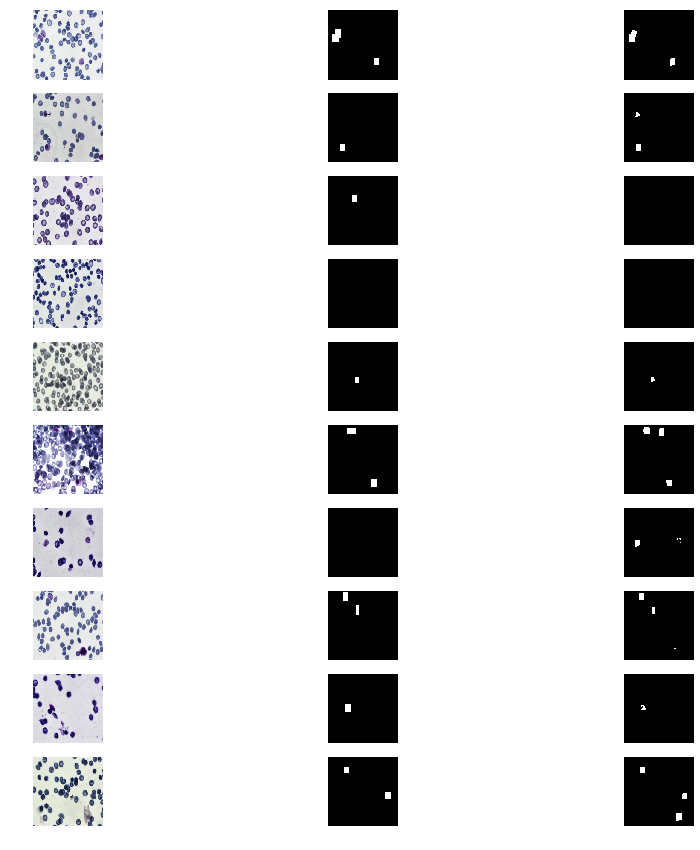

In [31]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

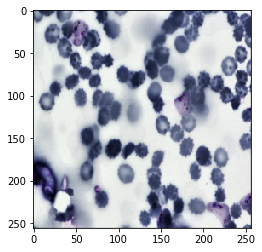

In [32]:
plt.imshow(X_train[0] )

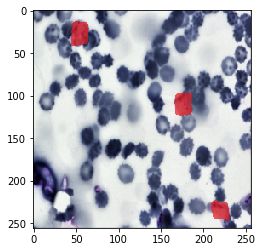

In [33]:
plt.imshow(X_train[0] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[0]>0, 1, np.nan)), cmap='Set1',alpha=0.7)


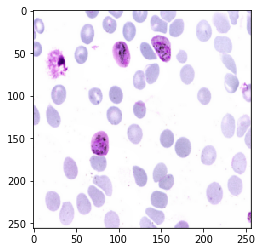

In [34]:
plt.imshow(X_train[4] ) 

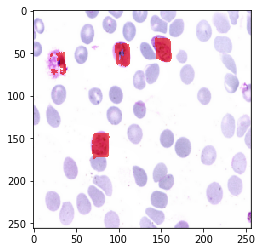

In [35]:
plt.imshow(X_train[4] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[4]>0,1, np.nan)), cmap='Set1',alpha=0.7)

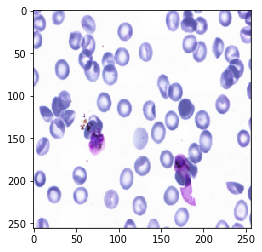

In [36]:
plt.imshow(X_train[7] ) 

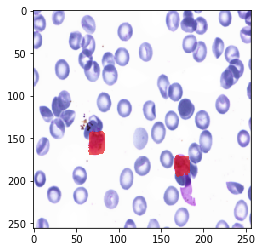

In [37]:
plt.imshow(X_train[7] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[7]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

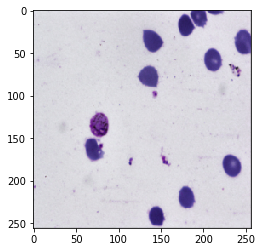

In [38]:
plt.imshow(X_train[9] )

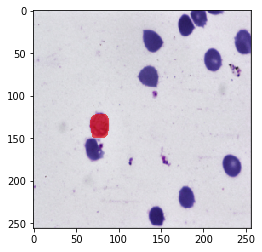

In [39]:
plt.imshow(X_train[9] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[9]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

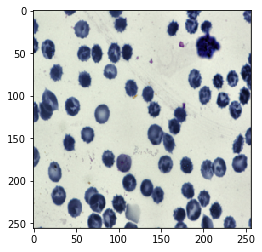

In [40]:
plt.imshow(X_train[50] ) 

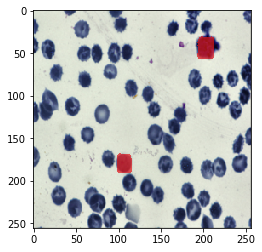

In [41]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

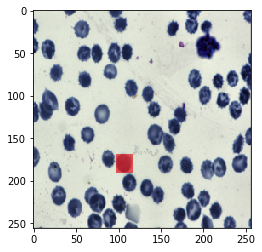

In [42]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(Y_train[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)